In [1]:
%load_ext autoreload
%autoreload 2

Using simpler models with the same results. Can this be considered a victory?

In [2]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..')))
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import classification_report

from utility.classification_utility import *

2025-01-02 22:12:12.960647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735852333.098966  159837 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735852333.138164  159837 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 22:12:13.381113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's start by building our beautiful dataset

In [3]:
cyc = '../dataset/cyclists_cleaned.csv'
races = '../dataset/races_cleaned.csv'
df = make_dataset_for_classification(races, cyc, make_stage_type=True, make_race_participants=True)

100.00%  


In [4]:
# dumb imputations
df['height'] = df['height'].fillna(df['height'].mean())
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['bmi'] = df['weight']/np.square(df['height']/100)
df['cyclist_age_rac'] = df['cyclist_age_rac'].fillna(df['cyclist_age_rac'].mean())
df['climb_total'] = df['climb_total'].fillna(df['length']*0.05) # could be differentiated by lengths
df['steepness'] = df['length'] / df['climb_total']

In [5]:
# for profile, let's use the big stick
# Features and target
# Add a column 'is_ITT' where 1 indicates stage_type is 'ITT', 0 otherwise
df['is_ITT'] = (df['stage_type'] == 'ITT').astype(int)
df_filtered = df[['length', 'climb_total', 'steepness', 'average_speed', 'is_ITT', 'profile']].dropna()
X = df_filtered[['length', 'climb_total', 'steepness', 'average_speed', 'is_ITT']]
y = df_filtered['profile']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# TODO: test the model
y_pred = clf.predict(X_test)
print(f"Accuracy: {np.mean(y_pred == y_test)}")
print(f"Feature importance: {clf.feature_importances_}")

Accuracy: 0.9991312777770783
Feature importance: [0.21644605 0.27903885 0.30263699 0.20187812 0.        ]


Well.. this might mean that the inferences over the climb total and the length were quite accurate

In [7]:
# Predict missing profiles
missing_profiles = df[df['profile'].isna()]
df.loc[missing_profiles.index, 'profile'] = clf.predict(missing_profiles[['length', 'climb_total', 'steepness', 'average_speed', 'is_ITT']])

In [8]:
TO_USE_COLS = [
    # over time
    'total_points',
    'avg_points_per_race', 
    'average_position',
    'avg_speed_cyclist', 
    'mean_stamina_index',
    'race_count',
    # race related
    'length',
    'climb_total', 
    'profile', 
    'startlist_quality', 
    'cyclist_age_rac', 
    'steepness', 
    'is_tarmac', 
    'stage_type',
    'season',
    'total_participants',
    # cyclist related
    'height',
    'weight',
    'bmi',
    'home_game',
    # for the split
    'date',
    'target'
]

df_to_use = df[TO_USE_COLS]

In [9]:
# useless
# season_dummies = pd.get_dummies(df['season'], prefix='season')
# df_to_use = pd.concat([df_to_use.drop(columns=['season']), season_dummies], axis=1)

In [10]:
df_tr, df_vl, df_ts = get_data_split(df_to_use)

df_tr = df_tr.drop(columns=['date'])
df_vl = df_vl.drop(columns=['date'])
df_ts = df_ts.drop(columns=['date'])

X_tr, y_tr = split_features_target(df_tr)
X_vl, y_vl = split_features_target(df_vl)
X_ts, y_ts = split_features_target(df_ts)

Normalize the features before predicting

In [11]:
scal = StandardScaler()
X_tr = scal.fit_transform(X_tr)
X_vl = scal.transform(X_vl)
X_ts = scal.transform(X_ts)

# Nn test

Let's build this model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_tr.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam()


model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[
    'accuracy',
    'recall'
    ])

Now fit it

In [ ]:
history = model.fit(
    X_tr, y_tr, 
    validation_data=(X_vl, y_vl), 
    epochs=10, 
    batch_size=64,
    verbose=2,
    callbacks=[early_stopping]
)

In [ ]:
val_pred = model.predict(X_vl)
val_pred = (val_pred > 0.5).astype(int)
print(classification_report(y_vl, val_pred))

# Grid Search

In [12]:
dict_learning = {
    'adam': tf.keras.optimizers.Adam(),
    'sgd': tf.keras.optimizers.SGD(),
    'lion': tf.keras.optimizers.Lion()
}

def build_model(num_layers=2, num_units=64, optimizer='adam', activation='relu', dropout=0.2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_tr.shape[1],)))
    
    model.add(tf.keras.layers.Dense(num_units, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout))
    
    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(num_units, activation=activation))
        model.add(tf.keras.layers.Dropout(dropout))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    opt = dict_learning[optimizer]
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'recall'])
    return model

# param_grid = {
#     'num_layers': [1, 2],
#     'num_units': [32, 64],
#     'optimizer': ['adam', 'sgd', 'lion'],
#     'activation': ['relu', 'tanh'],
#     'batch_size': [16, 32, 64],
#     'epochs': [5],
# }

2025-01-02 22:14:35.562490: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


This proto grid search has already been ran over various parameters. Without verbosity. Won't be uploading on git a long version of the last.

Nothing much changes between these different hyperparameters. Maybe the answer lies elsewhere, like in regularization: oversampling and dropout?

In [13]:
param_grid = {
    'dropout': [0.2],
    'num_layers': [2, 3],
    'num_units': [64, 128],
    'optimizer': ['adam'],
    'activation': ['relu'],
    'batch_size': [64],
    # 'batch_norm': [True],
    'epochs': [10],
}

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall',  
    patience=5,            
    mode='max',            
    restore_best_weights=True  
)

In [14]:
ratio = 0.35
# oversample = RandomOverSampler(sampling_strategy=ratio, random_state=42)
oversample = SMOTE(sampling_strategy=ratio, random_state=42)
oversampled_X, oversampled_y = oversample.fit_resample(X_tr, y_tr)

In [33]:
param_list = list(ParameterSampler(param_grid, n_iter=8, random_state=42))

for params in param_list:
    print(f"Training model with parameters: {params}")
    model = build_model(params['num_layers'], params['num_units'], params['optimizer'], params['activation'], params['dropout'])
    history = model.fit(
        oversampled_X, oversampled_y, 
        validation_data=(X_vl, y_vl), 
        epochs=params['epochs'], 
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[early_stopping]
    )
    val_pred = model.predict(X_vl)
    val_pred = (val_pred > 0.5).astype(int)
    # write metrics and params in a file
    with open('model_eval.txt', 'a') as f:
        f.write(f"Parameters: {params}, oversampled: {ratio}\n")
        f.write(classification_report(y_vl, val_pred))
        f.write('\n\n')


/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=8. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training model with parameters: {'optimizer': 'adam', 'num_units': 64, 'num_layers': 2, 'epochs': 10, 'dropout': 0.2, 'batch_size': 64, 'activation': 'relu'}
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step
Training model with parameters: {'optimizer': 'adam', 'num_units': 128, 'num_layers': 2, 'epochs': 10, 'dropout': 0.2, 'batch_size': 64, 'activation': 'relu'}
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step
Training model with parameters: {'optimizer': 'adam', 'num_units': 64, 'num_layers': 3, 'epochs': 10, 'dropout': 0.2, 'batch_size': 64, 'activation': 'relu'}
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step
Training model with parameters: {'optimizer': 'adam', 'num_units': 128, 'num_layers': 3, 'epochs': 10, 'dropout': 0.2, 'batch_size': 64, 'activation': 'relu'}
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step


Oversampling boosts recall to good levels but mutilates precision, while dropout does the opposite. Tuning them seems the best option
Two layers and more units seem to improve a bit the overall metrics.
As professor Micheli said, I have to listen to the neural network and move where it tells me. 
Also, early stopping and more epochs might help. Maybe let's reduce the parameters.

# Explanability

Let's see what can we infer from applying some explanability to these models! So far we don't move past 0.68, no matter what we do. Maybe shap can give us some insights

In [15]:
import shap

shap.initjs()

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# build a winning model
winnable = build_model()
winnable.fit(oversampled_X, oversampled_y, 
        validation_data=(X_vl, y_vl), 
        epochs=10, 
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping])

Epoch 1/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7648 - loss: 0.4932 - recall: 0.2794 - val_accuracy: 0.8512 - val_loss: 0.3804 - val_recall: 0.3903
Epoch 2/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7785 - loss: 0.4716 - recall: 0.3241 - val_accuracy: 0.8494 - val_loss: 0.3666 - val_recall: 0.4039
Epoch 3/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7805 - loss: 0.4674 - recall: 0.3366 - val_accuracy: 0.8587 - val_loss: 0.3631 - val_recall: 0.3353
Epoch 4/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7821 - loss: 0.4647 - recall: 0.3398 - val_accuracy: 0.8526 - val_loss: 0.3683 - val_recall: 0.3869
Epoch 5/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7826 - loss: 0.4630 - recall: 0.3442 - val_accuracy: 0.8502 - val_loss: 0.3685 - val_recall: 0.4008
Epoch 6/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7820 - loss: 0.4631 - recall: 0.3526 - val_accuracy: 0.8547 - val_loss: 0.3666 - val_r

In [17]:
# make X_vl into a DataFrame
X_df_vl = pd.DataFrame(X_vl, columns=df_tr.columns[:20])

In [39]:
sample_to_train = shap.sample(X_df_vl, 50)

In [50]:
def f(X):
    return winnable.predict(X).flatten()

In [72]:
# explain a bunch of predictions using shap

explainer = shap.KernelExplainer(f, sample_to_train.iloc[:50])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [83]:
shap_values = explainer.shap_values(X_df_vl.iloc[:100,:], nsamples=400)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step


  2%|▏         | 2/100 [00:01<01:18,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


  3%|▎         | 3/100 [00:02<01:16,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


  4%|▍         | 4/100 [00:03<01:19,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


  5%|▌         | 5/100 [00:04<01:16,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


  6%|▌         | 6/100 [00:04<01:17,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


  7%|▋         | 7/100 [00:05<01:18,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


  8%|▊         | 8/100 [00:06<01:17,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


  9%|▉         | 9/100 [00:07<01:14,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


 10%|█         | 10/100 [00:08<01:13,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


 11%|█         | 11/100 [00:08<01:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 12%|█▏        | 12/100 [00:09<01:07,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 13%|█▎        | 13/100 [00:10<01:06,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


 14%|█▍        | 14/100 [00:11<01:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step


 15%|█▌        | 15/100 [00:12<01:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step


 16%|█▌        | 16/100 [00:12<01:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


 17%|█▋        | 17/100 [00:13<01:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


 18%|█▊        | 18/100 [00:14<01:06,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 19%|█▉        | 19/100 [00:15<01:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


 20%|██        | 20/100 [00:15<01:02,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step


 21%|██        | 21/100 [00:16<01:05,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


 22%|██▏       | 22/100 [00:17<01:03,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


 23%|██▎       | 23/100 [00:18<01:02,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 24%|██▍       | 24/100 [00:19<00:59,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step


 25%|██▌       | 25/100 [00:20<00:58,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


 26%|██▌       | 26/100 [00:20<00:58,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step


 27%|██▋       | 27/100 [00:21<00:58,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step


 28%|██▊       | 28/100 [00:22<00:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 29%|██▉       | 29/100 [00:23<00:57,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step


 30%|███       | 30/100 [00:24<00:56,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step


 31%|███       | 31/100 [00:24<00:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


 32%|███▏      | 32/100 [00:25<00:54,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


 33%|███▎      | 33/100 [00:26<00:53,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step


 34%|███▍      | 34/100 [00:27<00:51,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


 35%|███▌      | 35/100 [00:27<00:50,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


 36%|███▌      | 36/100 [00:28<00:49,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


 37%|███▋      | 37/100 [00:29<00:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


 38%|███▊      | 38/100 [00:30<00:48,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


 39%|███▉      | 39/100 [00:31<00:47,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


 40%|████      | 40/100 [00:31<00:47,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step


 41%|████      | 41/100 [00:32<00:46,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step


 42%|████▏     | 42/100 [00:33<00:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


 43%|████▎     | 43/100 [00:34<00:48,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step


 44%|████▍     | 44/100 [00:35<00:47,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


 45%|████▌     | 45/100 [00:36<00:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step


 46%|████▌     | 46/100 [00:36<00:44,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


 47%|████▋     | 47/100 [00:37<00:42,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


 48%|████▊     | 48/100 [00:38<00:41,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step


 49%|████▉     | 49/100 [00:39<00:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


 50%|█████     | 50/100 [00:40<00:40,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


 51%|█████     | 51/100 [00:40<00:39,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


 52%|█████▏    | 52/100 [00:41<00:38,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 53%|█████▎    | 53/100 [00:42<00:36,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


 54%|█████▍    | 54/100 [00:43<00:35,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


 55%|█████▌    | 55/100 [00:43<00:34,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step


 56%|█████▌    | 56/100 [00:44<00:34,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


 57%|█████▋    | 57/100 [00:45<00:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


 58%|█████▊    | 58/100 [00:46<00:32,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


 59%|█████▉    | 59/100 [00:47<00:31,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


 60%|██████    | 60/100 [00:47<00:31,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


 61%|██████    | 61/100 [00:48<00:31,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


 62%|██████▏   | 62/100 [00:49<00:30,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step


 63%|██████▎   | 63/100 [00:50<00:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 64%|██████▍   | 64/100 [00:51<00:28,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


 65%|██████▌   | 65/100 [00:51<00:27,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step


 66%|██████▌   | 66/100 [00:52<00:26,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


 67%|██████▋   | 67/100 [00:53<00:25,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


 68%|██████▊   | 68/100 [00:54<00:24,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


 69%|██████▉   | 69/100 [00:54<00:23,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


 70%|███████   | 70/100 [00:55<00:23,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step


 71%|███████   | 71/100 [00:56<00:22,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


 72%|███████▏  | 72/100 [00:57<00:21,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


 73%|███████▎  | 73/100 [00:58<00:21,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 74%|███████▍  | 74/100 [00:58<00:19,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


 75%|███████▌  | 75/100 [00:59<00:19,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step


 76%|███████▌  | 76/100 [01:00<00:18,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step


 77%|███████▋  | 77/100 [01:01<00:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 78%|███████▊  | 78/100 [01:01<00:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


 79%|███████▉  | 79/100 [01:02<00:16,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


 80%|████████  | 80/100 [01:03<00:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step


 81%|████████  | 81/100 [01:04<00:15,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step


 82%|████████▏ | 82/100 [01:05<00:14,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


 83%|████████▎ | 83/100 [01:05<00:13,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


 84%|████████▍ | 84/100 [01:06<00:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 85%|████████▌ | 85/100 [01:07<00:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


 86%|████████▌ | 86/100 [01:08<00:10,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


 87%|████████▋ | 87/100 [01:08<00:10,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step


 88%|████████▊ | 88/100 [01:09<00:09,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step


 89%|████████▉ | 89/100 [01:10<00:08,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


 90%|█████████ | 90/100 [01:11<00:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


 91%|█████████ | 91/100 [01:12<00:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


 92%|█████████▏| 92/100 [01:12<00:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


 93%|█████████▎| 93/100 [01:13<00:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


 94%|█████████▍| 94/100 [01:14<00:04,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step


 95%|█████████▌| 95/100 [01:15<00:03,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 96%|█████████▌| 96/100 [01:15<00:03,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


 97%|█████████▋| 97/100 [01:16<00:02,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


 98%|█████████▊| 98/100 [01:17<00:01,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step


 99%|█████████▉| 99/100 [01:18<00:00,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [84]:
shap.force_plot(explainer.expected_value, shap_values, X_df_vl.iloc[:100,:])

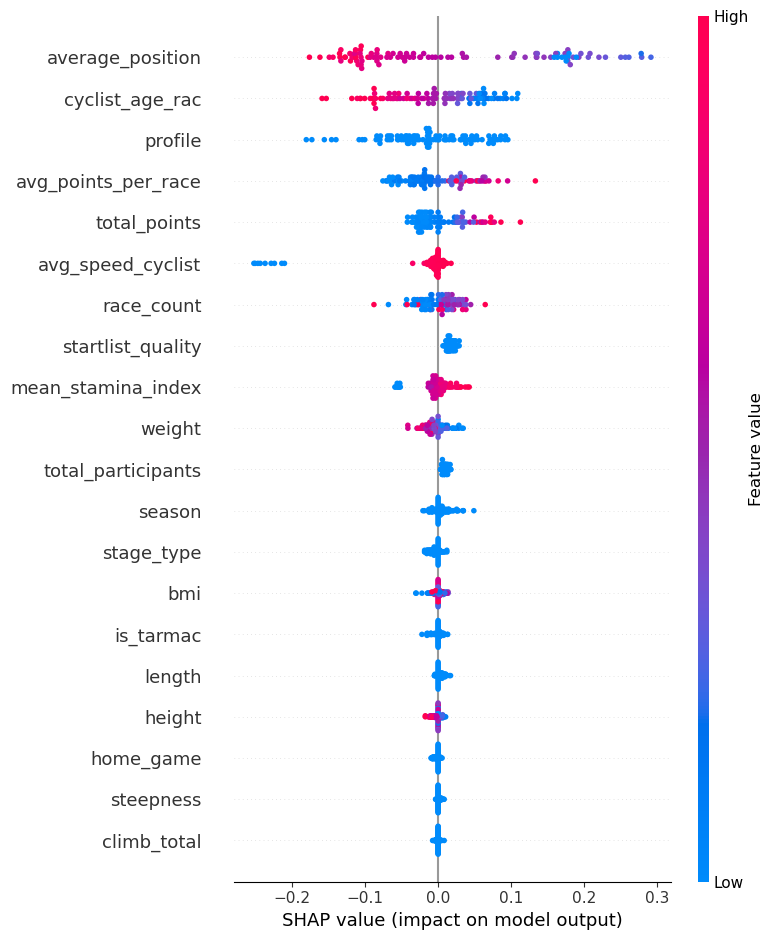

In [85]:
shap.summary_plot(shap_values, X_df_vl.iloc[:100,:])

Average Position and Cyclist Age:
    These features have the most significant impact on the model's output, with SHAP values distributed widely.
    Higher or lower values of these features strongly influence predictions, as indicated by the color gradient and range.

Profile and Average Points per Race:

    These features also play a critical role but have slightly less variance in their SHAP values compared to the top features.

Total Points and Average Speed Cyclist:

    Features like total points and cyclist speed seem moderately important, with a noticeable spread around the center.

Race Count and Startlist Quality:

    These have limited impact compared to other features but still contribute marginally.

Minor Features:

    Features such as BMI, height, home_game, and steepness have a minimal impact on the model, as indicated by their tightly clustered SHAP values around zero.